# Preprocessing data

In [1]:
import os
import pandas as pd
from src.preprocessing import Preprocessing

data_path = os.path.join(os.path.dirname(os.path.abspath('.')), 'data', 'train.csv')
preprocessing = Preprocessing(data_path, apply_ln=True)

In [2]:
df = preprocessing.read_and_parse_data()

In [3]:
df

,y
date,
2015-01-01,0.647925
2015-02-01,0.369720
2015-03-01,0.638453
2015-04-01,0.709385
2015-05-01,0.823487
...,...
2020-10-01,0.796836
2020-11-01,0.699149
2020-12-01,0.679824


# Data Analysis

Statsmodels lib is used to analyze the data decomposing it into trend, seasonality and residuals (systematic part).
For period param 12 is used to consider monthly data.

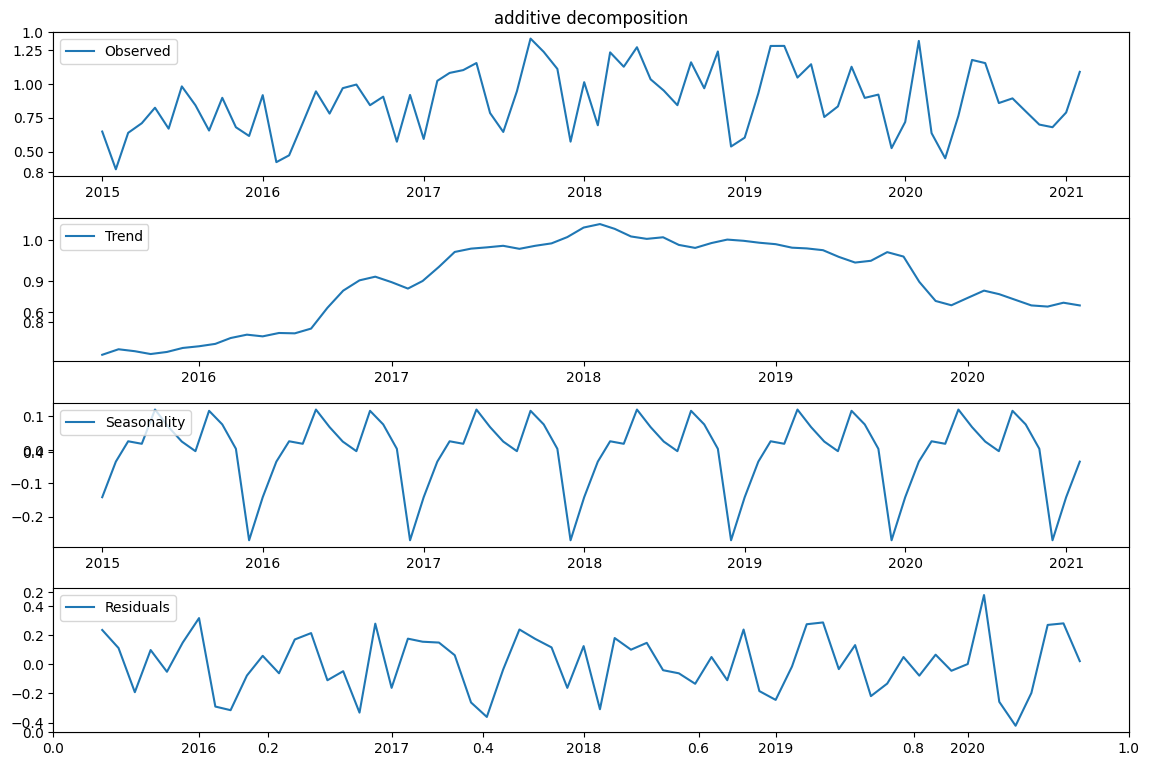

Residuals analysis for additive model
There is autocorrelation in the residuals for lags 1
There is autocorrelation in the residuals for lags 2
There is no autocorrelation in the residuals for lags 3
There is no autocorrelation in the residuals for lags 4
There is no autocorrelation in the residuals for lags 5
There is no autocorrelation in the residuals for lags 6
There is no autocorrelation in the residuals for lags 7
There is no autocorrelation in the residuals for lags 8
There is no autocorrelation in the residuals for lags 9
There is autocorrelation in the residuals for lags 10
There is autocorrelation in the residuals for lags 11


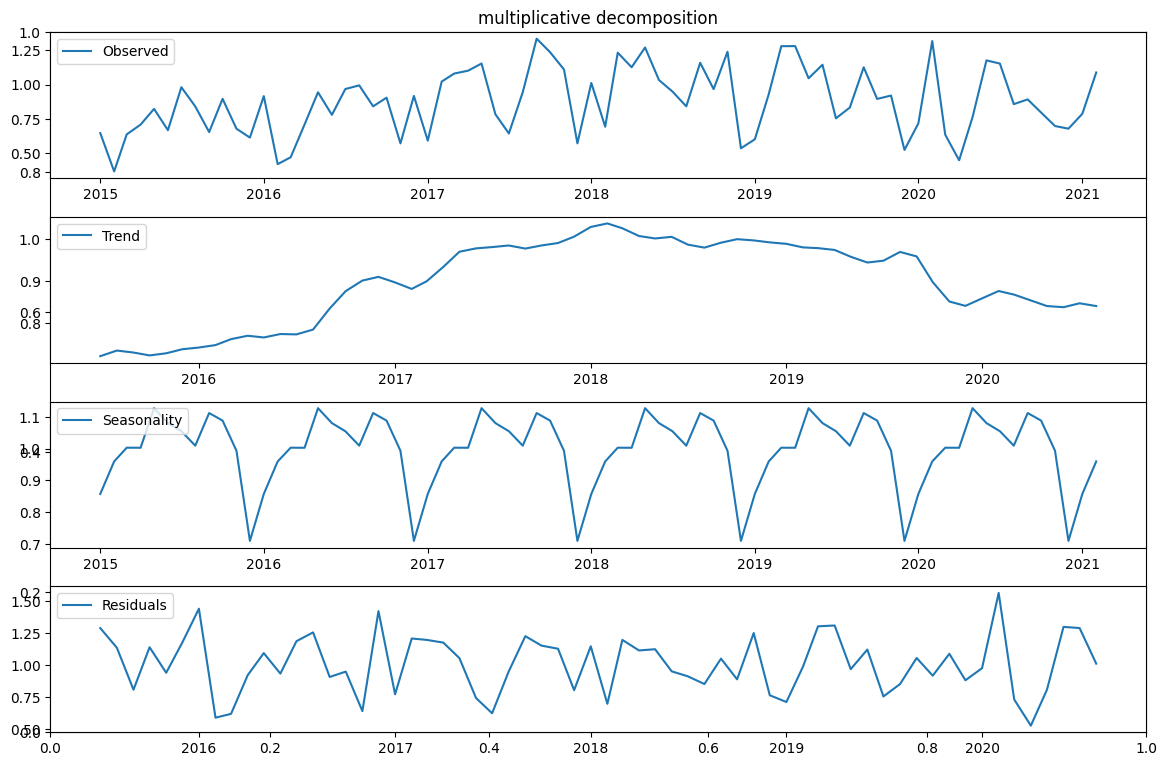

Residuals analysis for multiplicative model
There is autocorrelation in the residuals for lags 1
There is autocorrelation in the residuals for lags 2
There is no autocorrelation in the residuals for lags 3
There is no autocorrelation in the residuals for lags 4
There is autocorrelation in the residuals for lags 5
There is autocorrelation in the residuals for lags 6
There is autocorrelation in the residuals for lags 7
There is autocorrelation in the residuals for lags 8
There is autocorrelation in the residuals for lags 9
There is autocorrelation in the residuals for lags 10
There is autocorrelation in the residuals for lags 11


In [4]:
from src.analysis import decompose_analysis

PERIOD = 12
decompose_analysis(df['y'], PERIOD, save_image=False)

## Analysis

Considering additive and multiplicative models the decomposition is pretty similar, in both cases it's possible to notice that there is a seasonality in the data. The trend is not linear and the residuals are not constant.
It's interesting to note that seasons have a similar amplitude over the years.
By eye residuals are quite random this can suggest that seasonality and tren are well captured by the model.


### Residuals analysis

For residuals analysis Ljung-Box test is used to check if autocorrelation is present in the residuals.
Ideally we would like to see p-values greater than 0.05 which can suggest that there is autocorrelation in the residuals and this means that the systematic part (trend, seasonality and ) from the data was captured by the model.

## Analyzing stationary

Stationary is a key concept in time series analysis. A time series is said to be stationary if its statistical properties do not change over time. In other words, it has constant mean and variance, and covariance is independent of time.
To check if data is stationary two tests are used: Dickey-Fuller and Kwiatkowski-Phillips-Schmidt-Shin. In noth cases If p-value is less than 0.05 then data is likely stationary.

In [5]:
from src.analysis import dickey_fuller_test, kpss_test

In [6]:
dickey_fuller_test(df['y'])

Dickey-fuller Statistic: -6.138212795219422
p-value: 8.089699660354181e-08
Critical Values: {'1%': -3.5232835753964475, '5%': -2.902030597326081, '10%': -2.5883710883843123}
Data is likely stationary


In [7]:
kpss_test(df['y'])

KPSS Statistic: 0.5086945603375992
p-value: 0.03970843235639658
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Data is likely stationary


### Tests analysis

From the previous tests it's possible to see that data is likely stationary. This is a good sign for time series analysis since.

# Modeling

In this section we will analyze the data with lags and try to forecast the data. Considering the previous analysis we can use a model that considers the seasonality and stationary.

In [8]:
NUM_LAGS = 12

In [9]:
df_lags = preprocessing.create_lagged_features(df, NUM_LAGS)

## Lags analysis

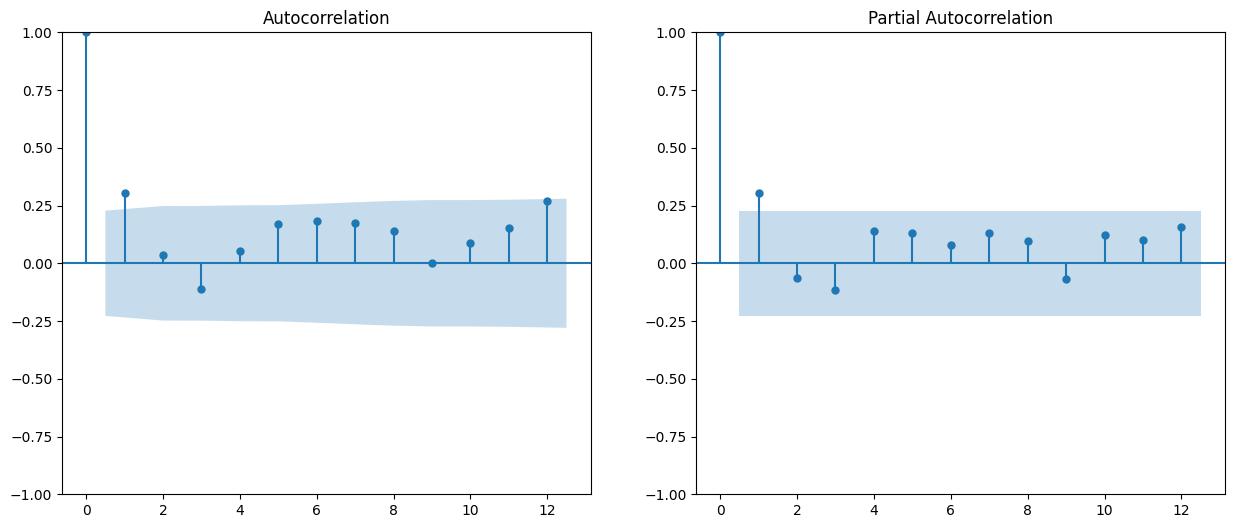

In [10]:
from src.visualizations import plot_acf_and_pacf

plot_acf_and_pacf(df['y'], num_lags=NUM_LAGS)

### ACF and PACF analysis

From the previous plots the lags 1, 5-7 and 12 the most import peaks then we can use these values to select the parameters for the ARIMA model. Anyways a grid search will be done to be sure about it.

## Models

Based on the previous analysis we can use ARIMA or SARIMAX models to forecast the data.
The parameters p, d, q, P, D, Q and s must be selected based on models with better fit and ACF and PACF plots.
In case of d parameter we can use 0 since the data is stationary and not differentiation is needed.

To evaluate model quality the data is split in train and test, considering 12 months for test.
The idea is to achieve at least 30% of accuracy in the forecast.


In [11]:
from src.modeling import arima_grid_search, sarimax_grid_search
from sktime.split import temporal_train_test_split

y_train, y_test = temporal_train_test_split(df['y'], test_size=12)

In [44]:
type(y_train)

pandas.core.series.Series

In [12]:
d = 0 # the data is stationary then d = 0 and its not necessary to differenciate the data

arima_grid_search_output = arima_grid_search(time_series=y_train, p_range=range(1, 13), q_range=range(1, 13), d=d)

# Step 4: Output the best model information
print(f'Best params: {arima_grid_search_output.best_params}')
print(f'AIC: {arima_grid_search_output.best_aic}')
print(f'BIC: {arima_grid_search_output.best_bic}')
print(arima_grid_search_output.best_model.summary())

Best params: {'best_p': 1, 'best_q': 5}
AIC: -5.578455084328326
BIC: 11.438619996032408
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   62
Model:                 ARIMA(1, 0, 5)   Log Likelihood                  10.789
Date:                Wed, 24 Apr 2024   AIC                             -5.578
Time:                        13:24:13   BIC                             11.439
Sample:                    01-01-2015   HQIC                             1.103
                         - 02-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8766      0.078     11.171      0.000       0.723       1.030
ar.L1          0.9216      0.064     14.416

#### ARIMA model analysis

The values of Skew and Kurtosis suggest normal distribution of residuals, with is supported by Jarque-Bera test with a p-value of 0.47 which is greater than 0.5.
Based on these stats we can say that model's assumptions about the error distribution are not violated and the model is likely providing reliable estimates.


#### ARIMA forecasting

In [13]:
import copy
from src.postprocessing import Postprocessing
from src.modeling.forecaster import Forecaster

postprocessing = Postprocessing(apply_ln=True)
arima_forecaster = Forecaster(arima_grid_search_output.best_model, postprocessing)
df_arima_forecast = arima_forecaster.forecast(steps=12)


y               mean   mean_se  mean_ci_lower  mean_ci_upper
2020-03-01  1.155070  0.197331       0.768308       1.541833
2020-04-01  1.062706  0.197664       0.675292       1.450119
2020-05-01  0.833696  0.198246       0.445141       1.222251
2020-06-01  0.817001  0.208393       0.408557       1.225444
2020-07-01  0.900657  0.209478       0.490087       1.311227
2020-08-01  0.898774  0.213836       0.479664       1.317884
2020-09-01  0.897038  0.217468       0.470810       1.323267
2020-10-01  0.895439  0.220505       0.463256       1.327622
2020-11-01  0.893965  0.223053       0.456789       1.331141
2020-12-01  0.892607  0.225194       0.451234       1.333979
2021-01-01  0.891355  0.226997       0.446449       1.336260
2021-02-01  0.890201  0.228516       0.442317       1.338085


In [14]:
# Getting original data to compare with the forecast, only if the data was transformed
df_normalized = copy.deepcopy(df)
df_normalized['y'] = postprocessing.postprocess(df_normalized['y'])

In [15]:
df_arima_full = pd.concat([df_normalized[:62], df_arima_forecast])

<Axes: title={'center': 'Original data'}, xlabel='date'>

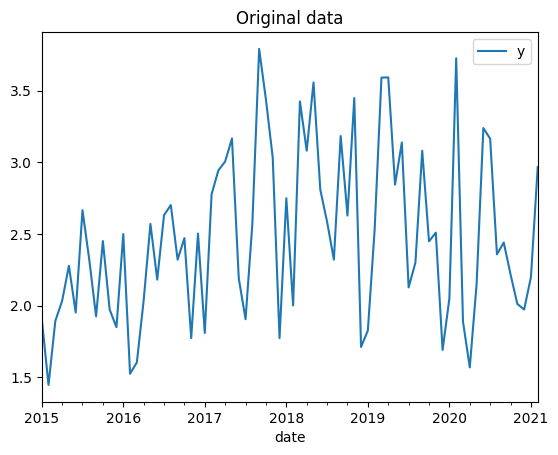

In [16]:
df_normalized.plot(title='Original data')

<Axes: title={'center': 'Forecast data'}>

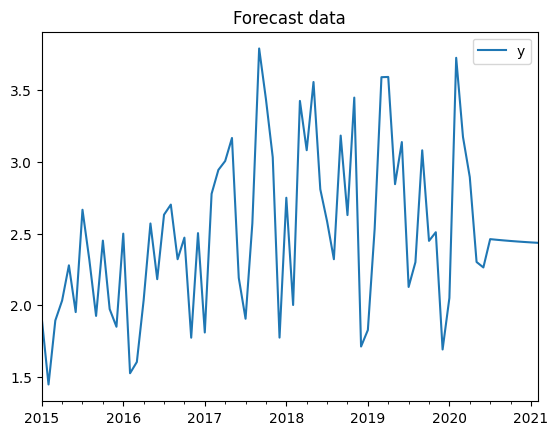

In [17]:
df_arima_full.plot(title='Forecast data')

In [18]:
correlation, p_value_corr = arima_forecaster.pred_correlation(y_pred=df_arima_forecast['y'], y_test=y_test)
print(f'Correlation {correlation}')
print(f'P value of spearman correlation {p_value_corr}')

Correlation -0.37762237762237766
P value of spearman correlation 0.22620604493502663


In [19]:
df_arima_forecast.to_csv("../data/arima_forecast_test.csv", index=False, header=True, columns=['date', 'y'])

### SARIMAX

In [20]:
# Set the range of parameters to search
p_range = d_range = q_range = range(0, 5)  # Autoregressive and moving average lags
P_range = D_range = Q_range = range(0, 2)  # Seasonal lags
s = 12  # Monthly data, so the seasonal period is 12

sarimax_grid_search_output = sarimax_grid_search(time_series=y_train, p_range=p_range, d_range=d_range, q_range=q_range, seasonal_p_range=P_range, seasonal_d_range=D_range, seasonal_q_range=Q_range, seasonal_period=s)
print(
    f'Best Model Parameters: {sarimax_grid_search_output.best_params}')
print(f'Best Model AIC: {sarimax_grid_search_output.best_aic}')
print(f'Best Model BIC: {sarimax_grid_search_output.best_bic}')


Best Model Parameters: {'p': 3, 'd': 1, 'q': 1, 'P': 1, 'D': 0, 'Q': 0}
Best Model AIC: -4.688106797628233
Best Model BIC: 6.283741581306337


In [21]:
print(sarimax_grid_search_output.best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   62
Model:             SARIMAX(3, 1, 1)x(1, 0, [], 12)   Log Likelihood                   8.344
Date:                             Wed, 24 Apr 2024   AIC                             -4.688
Time:                                     13:26:19   BIC                              6.284
Sample:                                 01-01-2015   HQIC                            -0.578
                                      - 02-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1073      0.133      0.808      0.419      -0.153       0.368
ar.L2          0.0508      

#### SARIMAX model analysis

Residual analysis suggest that the model is well fitted, the p-value of Ljung-Box test is greater than 0.05 which means that there is no autocorrelation in the residuals. The distribution of residuals is apparently normal as suggested by the values of Skew and Kurtosis and the p-value of Jarque-Bera test is greater than 0.05 which means that there is not evidence to conclude that data doesn't follow a normal distribution.

### SARIMAX forecasting

In [39]:
postprocessing = Postprocessing(apply_ln=True)
sarimax_forecaster = Forecaster(sarimax_grid_search_output.best_model, postprocessing)
df_sarimax_forecast = sarimax_forecaster.forecast(steps=12)

y               mean   mean_se  mean_ci_lower  mean_ci_upper
2020-03-01  1.231308  0.195600       0.847938       1.614677
2020-04-01  1.164743  0.197158       0.778320       1.551167
2020-05-01  0.870788  0.197813       0.483082       1.258494
2020-06-01  0.953894  0.210979       0.540382       1.367406
2020-07-01  0.854558  0.211375       0.440270       1.268846
2020-08-01  0.975112  0.211507       0.560566       1.389659
2020-09-01  1.056056  0.214029       0.636566       1.475545
2020-10-01  0.979207  0.214381       0.559028       1.399386
2020-11-01  0.946057  0.214606       0.525437       1.366676
2020-12-01  0.822544  0.214715       0.401710       1.243378
2021-01-01  0.882746  0.214695       0.461952       1.303540
2021-02-01  1.085781  0.214672       0.665032       1.506531


In [29]:
df_sarimax_full = pd.concat([df_normalized[:62], df_sarimax_forecast])

<Axes: title={'center': 'Original data'}, xlabel='date'>

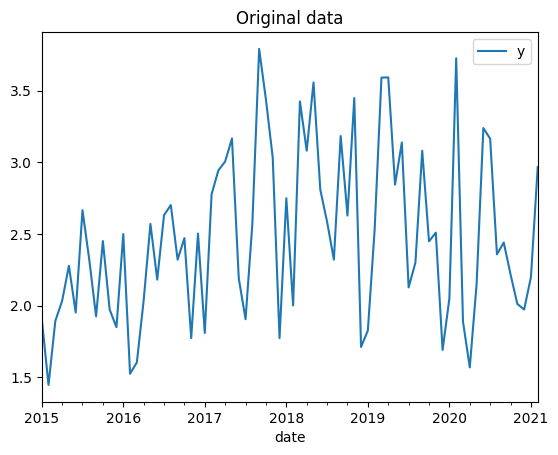

In [30]:
df_normalized.plot(title='Original data')

<Axes: title={'center': 'Forecast data'}>

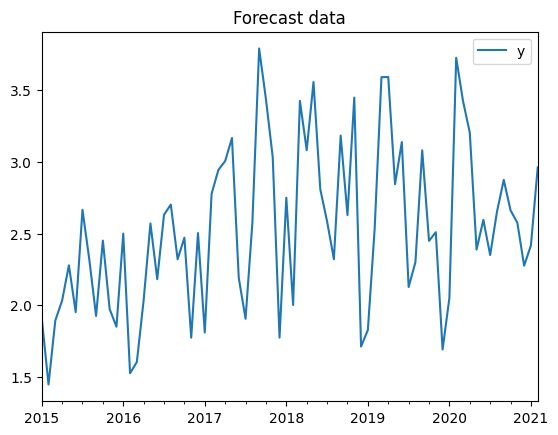

In [32]:
df_sarimax_full.plot(title='Forecast data')

In [38]:
correlation, p_value_corr = sarimax_forecaster.pred_correlation(y_pred=df_sarimax_forecast['y'], y_test=y_test)
print(f'Correlation {correlation}')
print(f'P value of spearman correlation {p_value_corr}')

Correlation -0.16083916083916086
P value of spearman correlation 0.6175234895401425


In [27]:
df_sarimax_forecast.to_csv("../data/sorimax_forecast_test.csv", index=False, header=True, columns=['date', 'y'])

# Metrics imputation

In [40]:
from src.evaluation.metrics import compare_model_metrics

In [41]:
predictions = {
    "arima": df_arima_forecast['y'],
    "sarimax": df_sarimax_forecast['y'],
}

y_test_normalized = postprocessing.postprocess(y_test)

metric_output = compare_model_metrics(predictions, y_test_normalized)

The best metric is mape_arima


In [43]:
print(metric_output)

{'mae_arima': 0.5378966397693975, 'mse_arima': 0.4738384563674692, 'mape_arima': 0.25081920421323817, 'mae_sarimax': 0.5944063068154847, 'mse_sarimax': 0.5917097811007294, 'mape_sarimax': 0.2883969458925491}


In [42]:
metric_output.get('mape_arima')

0.25081920421323817

# Research other models

#TODO: the idea of using new models was to compare the outputs generated by them and compare against arima and sarimax to see if they are better or not.
In this line prophet was considered only for validation purposes
The follow part is not completed and is WIP to be finished in the future.

## SKTIME models

In [29]:
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon

df.index = pd.PeriodIndex(df.index, freq="M")
y_train, y_test = temporal_train_test_split(df['y'], test_size=12)

model = AutoETS(auto=True, sp=12, n_jobs=-1)

model.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [30]:
#fh = ForecastingHorizon([i+1 for i in range(12)], is_relative=True)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred_ets = model.predict(fh=fh)

In [39]:
y_pred_ets

date
2020-03    2.831520
2020-04    2.834739
2020-05    2.837819
2020-06    2.840765
2020-07    2.843584
2020-08    2.846280
2020-09    2.848860
2020-10    2.851328
2020-11    2.853690
2020-12    2.855949
2021-01    2.858110
2021-02    2.860177
Freq: M, Name: y, dtype: float64

# Research with prophet for comparison

In [263]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [276]:
df["ds"] = df.index
df_prophet = df[["ds", "y"]]
df_prophet = df_prophet.reset_index()[["ds", "y"]]

In [277]:
df_prophet

,ds,y
0,2015-01-01,1.91157
1,2015-02-01,1.44733
2,2015-03-01,1.89355
3,2015-04-01,2.03274
4,2015-05-01,2.27843
...,...,...
69,2020-10-01,2.21851
70,2020-11-01,2.01204
71,2020-12-01,1.97353
72,2021-01-01,2.19952


In [281]:

m = Prophet(yearly_seasonality=True)
m.fit(df_prophet)

01:39:32 - cmdstanpy - INFO - Chain [1] start processing
01:39:32 - cmdstanpy - INFO - Chain [1] done processing


In [290]:
m.make_future_dataframe(periods=12, freq='m', include_history=False)

,ds
0,2021-02-28
1,2021-03-31
2,2021-04-30
3,2021-05-31
4,2021-06-30
5,2021-07-31
6,2021-08-31
7,2021-09-30
8,2021-10-31
9,2021-11-30


In [294]:
from dateutil.relativedelta import relativedelta

last_date = df_prophet.ds.max()
future_dates = [last_date + relativedelta(months=1, day=1)]
for _ in range(11):  # We already have the first month
    # Add a month and set the day to 1 to get the first day of the next month
    future_dates.append(future_dates[-1] + relativedelta(months=1))

# Convert the list of dates to a DataFrame
df_future = pd.DataFrame({'ds': future_dates})


In [296]:
forecast = m.predict(df_future)

In [297]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-03-01,2.660371,2.111527,3.398413,2.660371,2.660372,0.106632,0.106632,0.106632,0.106632,0.106632,0.106632,0.0,0.0,0.0,2.767003
1,2021-04-01,2.667611,2.150220,3.423586,2.667609,2.667613,0.099321,0.099321,0.099321,0.099321,0.099321,0.099321,0.0,0.0,0.0,2.766932
2,2021-05-01,2.674617,2.449169,3.745949,2.674612,2.674623,0.403462,0.403462,0.403462,0.403462,0.403462,0.403462,0.0,0.0,0.0,3.078079
3,2021-06-01,2.681857,2.299598,3.533101,2.681849,2.681866,0.243923,0.243923,0.243923,0.243923,0.243923,0.243923,0.0,0.0,0.0,2.925780
4,2021-07-01,2.688864,2.195872,3.463596,2.688851,2.688878,0.184077,0.184077,0.184077,0.184077,0.184077,0.184077,0.0,0.0,0.0,2.872940
5,2021-08-01,2.696104,2.152629,3.370063,2.696086,2.696122,0.046195,0.046195,0.046195,0.046195,0.046195,0.046195,0.0,0.0,0.0,2.742299
6,2021-09-01,2.703344,2.425780,3.638075,2.703321,2.703367,0.344965,0.344965,0.344965,0.344965,0.344965,0.344965,0.0,0.0,0.0,3.048308
7,2021-10-01,2.710350,2.242863,3.524746,2.710321,2.710379,0.167803,0.167803,0.167803,0.167803,0.167803,0.167803,0.0,0.0,0.0,2.878153
8,2021-11-01,2.717590,2.019909,3.345547,2.717556,2.717625,-0.042237,-0.042237,-0.042237,-0.042237,-0.042237,-0.042237,0.0,0.0,0.0,2.675353
9,2021-12-01,2.724596,1.656300,2.907253,2.724555,2.724638,-0.425302,-0.425302,-0.425302,-0.425302,-0.425302,-0.425302,0.0,0.0,0.0,2.299295


In [309]:
forecast.yhat

0     2.767003
1     2.766932
2     3.078079
3     2.925780
4     2.872940
5     2.742299
6     3.048308
7     2.878153
8     2.675353
9     2.299295
10    2.508358
11    2.890854
Name: yhat, dtype: float64